In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.3     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
source("../scripts/manifold_2d_proj_hr.R")
scdb_init("../scrna_db/", force_reinit=T)

mat_id <- "exe"
mc_id <- "exe"

mat <- scdb_mat(mat_id)
mc <- scdb_mc(mc_id)
gset = scdb_gset("exe")
mc2d <- scdb_mc2d(id = "exe_umap")

md <- mat@cell_metadata

fig_dir <- "../figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

initializing scdb to ../scrna_db/



In [3]:
exe_cells = colnames(mat@mat)[mat@cell_metadata[colnames(mat@mat),"Experiment"] != "Wildtype project"]
exe_cells_f = exe_cells[!is.na(md[exe_cells,"time_bin"])]

rank_vs_ct = table(mc@colors[mc@mc[exe_cells_f]],mat@cell_metadata[exe_cells_f,"transcriptional_rank"])
rank_vs_ct = rank_vs_ct[mc@color_key$color,]
rank_vs_ct = t(t(rank_vs_ct)/colSums(rank_vs_ct))

emb_age_df = unique(mat@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank",
                                                    "time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sum_age_exe <- emb_age_df %>% 
  group_by(time_bin) %>% 
  summarise(mean=round(mean(developmental_time),1))
sum_age_exe <- as.data.frame(sum_age_exe)

sc_time_annot = data.frame(cell = exe_cells_f,
                           embryo = mat@cell_metadata[exe_cells_f,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

col_to_ct =  mc@color_key$group
names(col_to_ct) = mc@color_key$color
ct_to_col = mc@color_key$color
names(ct_to_col) = mc@color_key$group

col_to_rank = c(1:nrow(mc@color_key))
names(col_to_rank) = mc@color_key$color
mc_time = tapply(sc_time,mc@mc[names(sc_time)],mean)
mc_new_ord = as.numeric(names(mc_time[order(as.numeric(mc_time))]))

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

annotation_col = data.frame(ct = col_to_ct[mc@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

In [4]:
chorion_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[1]]
tsc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[2]]
tsc2_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[3]]
spt_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[4]]
epc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[5]]
tgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[6]]
ptgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[7]]
spa_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[8]]

chorion_mcs = which(mc@colors == mc@color_key$color[1])
tsc_mcs = which(mc@colors == mc@color_key$color[2])
tsc2_mcs = which(mc@colors == mc@color_key$color[3])
spt_mcs = which(mc@colors == mc@color_key$color[4])
epc_mcs = which(mc@colors == mc@color_key$color[5])
tgc_mcs = which(mc@colors == mc@color_key$color[6])
ptgc_mcs = which(mc@colors == mc@color_key$color[7])
spa_mcs = which(mc@colors == mc@color_key$color[8])

chorion_mcs_ord = mc_new_ord[which(mc_new_ord %in% chorion_mcs)]
tsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc_mcs)]
tsc2_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc2_mcs)]
spt_mcs_ord = mc_new_ord[which(mc_new_ord %in% spt_mcs)]
epc_mcs_ord = mc_new_ord[which(mc_new_ord %in% epc_mcs)]
tgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tgc_mcs)]
ptgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% ptgc_mcs)]
spa_mcs_ord = mc_new_ord[which(mc_new_ord %in% spa_mcs)]

mcs_all <- c(tsc_mcs_ord,tsc2_mcs_ord,chorion_mcs_ord,spt_mcs_ord,epc_mcs_ord,tgc_mcs_ord,spa_mcs_ord,ptgc_mcs_ord)
mcs_epc_lineage <- c(tgc_mcs_ord,epc_mcs_ord,spt_mcs_ord)
mcs_chorion_lineage <- c(tsc_mcs_ord,chorion_mcs_ord)

In [7]:
##### Fig4c (FACS analysis lineage) ######
mc_embexe = scdb_mc("embexe_recolored")
mat_embexe = scdb_mat("embexe")
mc2d_embexe <- scdb_mc2d("embexe_recolored_umap")



In [ ]:
lin_trace_embryos = grep("lin",unique(mat_embexe@cell_metadata[names(mc_embexe@mc),"embryo"]),v = T)
cls_lin = names(mc_embexe@mc)[mat_embexe@cell_metadata[names(mc_embexe@mc),"embryo"] 
                              %in% lin_trace_embryos]

cls <- names(mc_embexe@mc)[as.numeric(mc_embexe@mc) %in% which(mc_embexe@colors %in% mc_embexe@color_key$color[mc_embexe@color_key$group %in% mc_embexe@color_key$group[-c(33,34)]])]
cls_lin <- intersect(cls_lin,cls)

FCS.df <- mat_embexe@cell_metadata[cls_lin,c("tdtomato_a","gfp_a")]
FCS.df <- FCS.df[!is.na(FCS.df$tdtomato_a),]
FCS.df$col <- mc_embexe@colors[mc_embexe@mc[rownames(FCS.df)]]
FCS.df$gfp_n <- FCS.df$gfp_a - min(FCS.df$gfp_a) 
FCS.df$tdtomato_n <- FCS.df$tdtomato_a - min(FCS.df$tdtomato_a) 
FCS.df <- FCS.df[!is.na(FCS.df$col),]

cls_emb <- names(mc_embexe@mc)[as.numeric(mc_embexe@mc) %in% which(mc_embexe@colors %in% mc_embexe@color_key$color[mc_embexe@color_key$group %in% mc_embexe@color_key$group[1:32]])]
cls_emb <- cls_emb[cls_emb %in% cls_lin]

cls_exe <- names(mc_embexe@mc)[as.numeric(mc_embexe@mc) %in% which(mc_embexe@colors %in% mc_embexe@color_key$color[mc_embexe@color_key$group %in% mc_embexe@color_key$group[35:42]])]
cls_exe <- cls_exe[cls_exe %in% cls_lin]

gfp_positive <- rownames(FCS.df)[log10(FCS.df$gfp_n + 500) > 3.15]
gfp_positive_per_all <- paste0(round(100*length(gfp_positive)/length(cls_lin),2),"%",sep="")

gfp_positive_per_exe <- gfp_positive[gfp_positive %in% cls_exe]
gfp_positive_per_exe <- paste0(round(100*length(gfp_positive_per_exe)/length(cls_exe),2),"%",sep="")

gfp_positive_per_emb <- gfp_positive[gfp_positive %in% cls_emb]
gfp_positive_per_emb <- paste0(round(100*length(gfp_positive_per_emb)/length(cls_emb),2),"%",sep="")

mCherry_positive <- rownames(FCS.df)[log10(FCS.df$tdtomato_n + 500) > 2.9]
mCherry_positive_per_all <- paste0(round(100*length(mCherry_positive)/length(cls_lin),2),"%",sep="")

mCherry_positive_per_exe <- mCherry_positive[mCherry_positive %in% cls_exe]
mCherry_positive_per_exe <- paste0(round(100*length(mCherry_positive_per_exe)/length(cls_exe),2),"%",sep="")

mCherry_positive_per_emb <- mCherry_positive[mCherry_positive %in% cls_emb]
mCherry_positive_per_emb <- paste0(round(100*length(mCherry_positive_per_emb)/length(cls_emb),2),"%",sep="")

gfp_negative <- rownames(FCS.df)[log10(FCS.df$gfp_n + 500) < 3.15]
gfp_negative_per_all <- paste0(round(100*length(gfp_negative)/length(cls_lin),2),"%",sep="")
gfp_negative_per_exe <- paste0(round(100*length(gfp_negative[gfp_negative %in% cls_exe])/length(cls_exe),2),"%",sep="")
gfp_negative_per_emb <- paste0(round(100*length(gfp_negative[gfp_negative %in% cls_emb])/length(cls_emb),2),"%",sep="")

mCherry_negative <- rownames(FCS.df)[log10(FCS.df$tdtomato_n + 500) < 2.9]
mCherry_negative_per_all <- paste0(round(100*length(mCherry_negative)/length(cls_lin),2),"%",sep="")
mCherry_negative_per_exe <- paste0(round(100*length(mCherry_negative[mCherry_negative %in% cls_exe])/length(cls_exe),2),"%",sep="")
mCherry_negative_per_emb <- paste0(round(100*length(mCherry_negative[mCherry_negative %in% cls_emb])/length(cls_emb),2),"%",sep="")

gfp_mCherry_negative <- intersect(gfp_negative,mCherry_negative)
gfp_mCherry_negative_per_all <- paste0(round(100*length(gfp_mCherry_negative)/length(cls_lin),2),"%",sep="")

gfp_mCherry_negative_exe <- gfp_mCherry_negative[gfp_mCherry_negative %in% cls_exe]
gfp_mCherry_negative_exe <- paste0(round(100*length(gfp_mCherry_negative_exe)/length(cls_exe),2),"%",sep="")

gfp_mCherry_negative_per_emb <- gfp_mCherry_negative[gfp_mCherry_negative %in% cls_emb]
gfp_mCherry_negative_per_emb <- paste0(round(100*length(gfp_mCherry_negative_per_emb)/length(cls_emb),2),"%",sep="")

gfp_density <- density(log10(FCS.df$gfp_n + 500),bw = 0.01)
# plot(gfp_density,
#      main = "GFP density (Green: GFP-positive)")
# x_low <- min(which(gfp_density$x >= 3.15))
# x_high <- max(which(gfp_density$x >= 3.15))
# with(gfp_density,  
#      polygon(x = c(x[c(x_low, x_low:x_high, x_high)]),
#              y = c(0, y[x_low:x_high], 0),
#              col = "green"))

mcherry_density <- density(log10(FCS.df$tdtomato_n + 500),bw = 0.003)
# plot(mcherry_density)
# x_low <- min(which(gfp_density$x < 3.15))
# x_high <- max(which(gfp_density$x < 3.15))
# with(mcherry_density,  
#      polygon(x = c(x[c(x_low, x_low:x_high, x_high)]),
#              y = c(0, y[x_low:x_high], 0),
#              col = "red"))

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
mc2d_emb <- scdb_mc2d(id = "emb_umap")

md <- mat_emb@cell_metadata

# manifold2dproj_hr(mc2d_id = "emb_umap",
#                   mc_id = "emb",
#                   mat_id = "emb",
#                   plot_mc = F,
#                   plot_par = "lin_trace",
#                   sc_point_size = 1.5,
#                   studio_plot = T)

# manifold2dproj_hr(mc2d_id = "exe_umap",
#                   mc_id = "exe",
#                   mat_id = "exe",
#                   plot_mc = F,
#                   plot_par = "lin_trace",
#                   sc_point_size = 1.5,
#                   studio_plot = T)


# manifold2dproj_hr(mc2d_id = "emb_umap",
#                   mc_id = "emb",
#                   mat_id = "emb",
#                   plot_mc = F,
#                   plot_par = "gfp_pos",
#                   sc_point_size = 1.5,
#                   studio_plot = T)

# manifold2dproj_hr(mc2d_id = "exe_umap",
#                   mc_id = "exe",
#                   mat_id = "exe",
#                   plot_mc = F,
#                   plot_par = "gfp_pos",
#                   sc_point_size = 1.5,
#                   studio_plot = T)

# manifold2dproj_hr(mc2d_id = "emb_umap",
#                   mc_id = "emb",
#                   mat_id = "emb",
#                   plot_mc = F,
#                   plot_par = "mcherry_pos",
#                   sc_point_size = 1.5,
#                   studio_plot = T)

# manifold2dproj_hr(mc2d_id = "exe_umap",
#                   mc_id = "exe",
#                   mat_id = "exe",
#                   plot_mc = F,
#                   plot_par = "mcherry_pos",
#                   sc_point_size = 1.5,
#                   studio_plot = T)

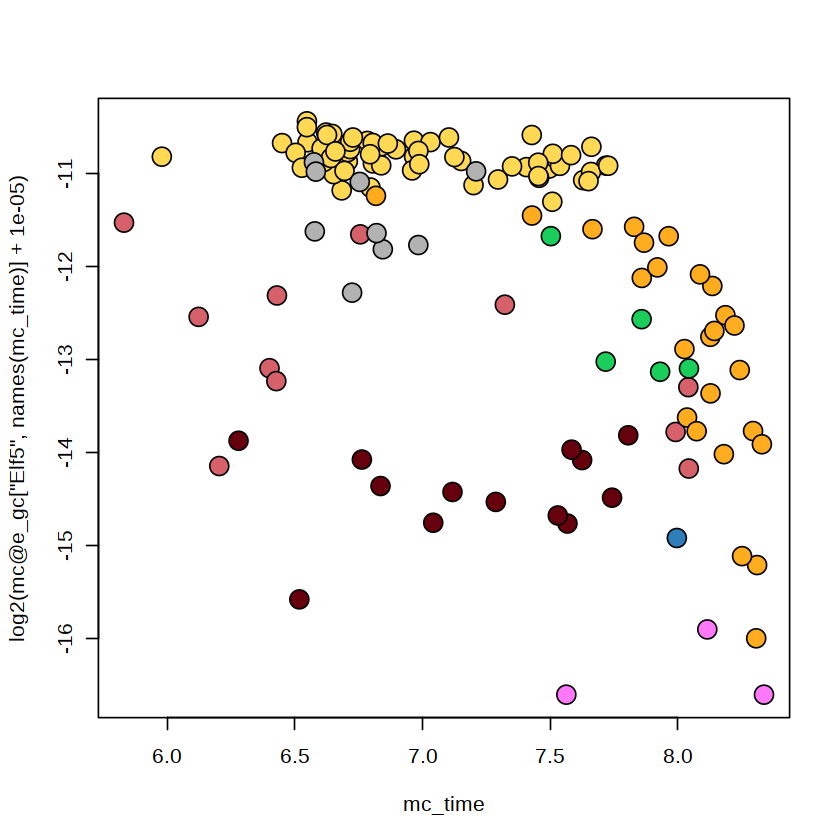

In [5]:
##### Fig4d (Elf5 expression over time) ######
mc_time = tapply(sc_time,mc@mc[names(sc_time)],mean)
plot(x = mc_time, y = log2(mc@e_gc["Elf5",names(mc_time)] + 1e-5), bg = as.character(mc@colors), pch = 21, col = "black", cex = 2)

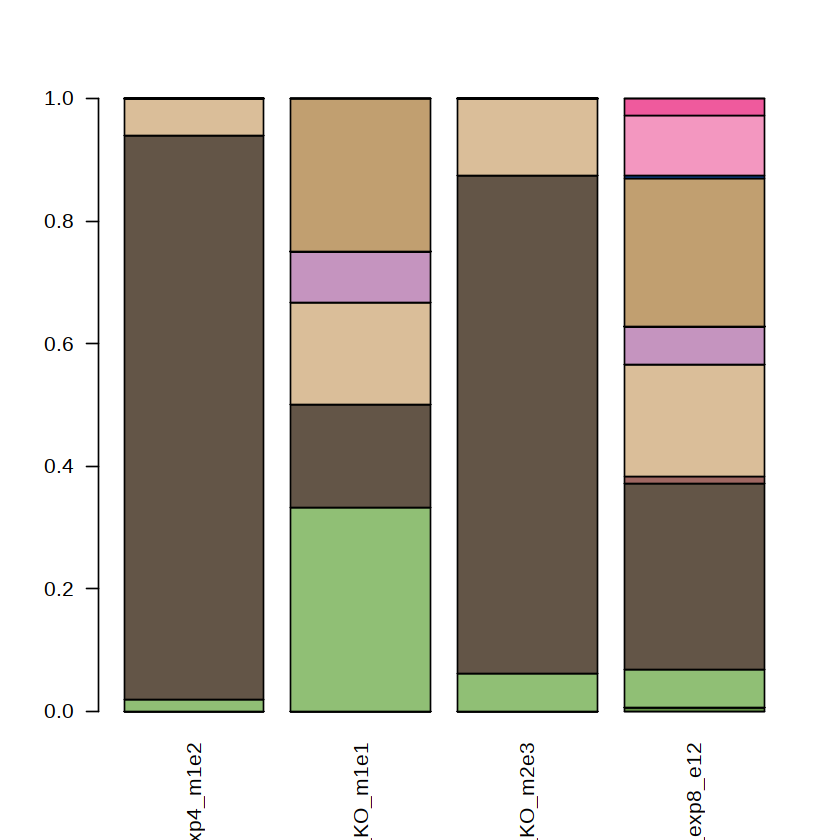

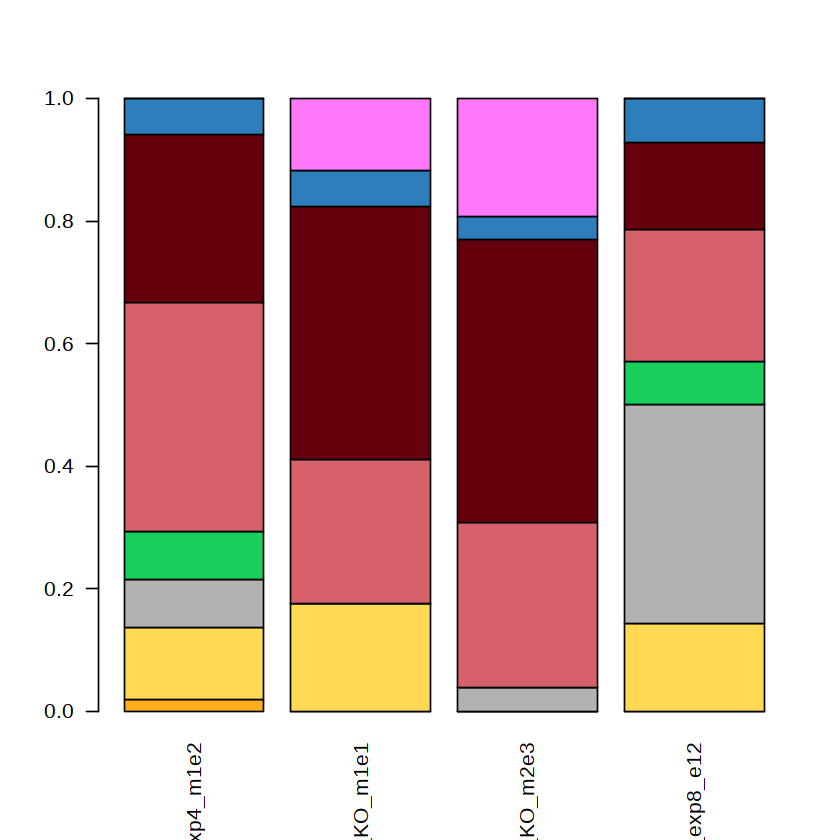

In [17]:
##### Fig4g (Ct composition elf5) ######
load("../data/elf5_embexe/color_annotation/cmp_annot.Rda")
mat_wt = scdb_mat("embexe")
mc_wt = scdb_mc("embexe_recolored")

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_elf5 = scdb_mat("elf5")
mat = scdb_mat("elf5_embexe")
md_elf5 <- mat_elf5@cell_metadata

ko_embs <- c("elf5_exp6_KO_m1e1","elf5_exp4_m1e2","elf5_exp6_KO_m2e3","elf5_ko_exp8_e12")

ko_cls <- rownames(mat_elf5@cell_metadata)[mat_elf5@cell_metadata$embryo %in% ko_embs]
ko_cls <- ko_cls[ko_cls %in% names(cmp_annot$query_cls_col)]

emb_cols <- mc_embexe@color_key$color[1:38]
exe_cols <- mc_embexe@color_key$color[43:50]

elf5_annotations <- data.frame(embryo = mat_elf5@cell_metadata[names(cmp_annot$query_cls_col),"embryo"],
                               cell_type_color = array(cmp_annot$query_cls_col),
                               row.names = names(cmp_annot$query_cls_col))

# KO cell type frequencies:
embryo_to_col_ko <- table(factor(x = elf5_annotations[elf5_annotations$embryo %in% ko_embs,"cell_type_color"],
                                 levels = mc_embexe@color_key$color),
                          elf5_annotations[elf5_annotations$embryo %in% ko_embs,"embryo"])

embryo_to_col_ko_emb <- embryo_to_col_ko[emb_cols,] # subset of embryonic cell types
embryo_to_col_ko_exe <- embryo_to_col_ko[exe_cols,] # subset of ExE cell types

embryo_to_col_ko_emb_n <- t(t(embryo_to_col_ko_emb)/colSums(embryo_to_col_ko_emb))
embryo_to_col_ko_exe_n <- t(t(embryo_to_col_ko_exe)/colSums(embryo_to_col_ko_exe))

barplot(embryo_to_col_ko_emb_n,
        col = rownames(embryo_to_col_ko_emb_n),
        las = 2)

barplot(embryo_to_col_ko_exe_n,
        col = rownames(embryo_to_col_ko_exe_n),
        las = 2)

In [18]:
##### Fig4h (Gene expression barplots) ######
double_positive_cells <- read.csv(file = "../data/elf5_embexe/double_pos_cells.csv")[,2]
load("../data/elf5_embexe/color_annotation/cmp_annot.Rda")
time_match_elf5 <- read.table("../data/elf5_embexe/elf5_infered_transcriptional_age.tsv",sep = "\t")
ko_embs <- c("elf5_exp6_KO_m1e1","elf5_exp4_m1e2","elf5_exp6_KO_m2e3","elf5_ko_exp8_e12")

ko_cls <- rownames(mat_elf5@cell_metadata)[mat_elf5@cell_metadata$embryo %in% ko_embs]
ko_cls <- ko_cls[ko_cls %in% names(cmp_annot$query_cls_col)]

ko_cls_exe <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] %in% mc_wt@color_key$color[43:50]]
wt_cls_exe <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% mc_wt@color_key$color[43:50]]

embryo_age_df = md_exe[,c("cell","embryo","time_bin","developmental_time")]
embryo_age_df = embryo_age_df[order(embryo_age_df$developmental_time),]
embryo_age_df <- embryo_age_df[! is.na(embryo_age_df$time_bin),]
rownames(embryo_age_df) <- embryo_age_df$cell

sum_age_embryo <- embryo_age_df  %>%  group_by(time_bin) %>% summarise(mean=round(mean(developmental_time),1))
sum_age_embryo <- as.data.frame(sum_age_embryo)
rownames(sum_age_embryo) <- sum_age_embryo$mean

embryo_age_df <- embryo_age_df[wt_cls_exe,]
embryo_age_df <- embryo_age_df[embryo_age_df$cell %in% colnames(mat@mat),]

elf5_timing_df <- time_match_elf5[time_match_elf5$embryo %in% ko_embs,]
elf5_timing_df <- elf5_timing_df[order(elf5_timing_df$developmental_time),]

sum_times_elf5 <- data.frame("cell" = rownames(mat@cell_metadata)[mat@cell_metadata$embryo %in% elf5_timing_df$embryo],
                             row.names = rownames(mat@cell_metadata)[mat@cell_metadata$embryo %in% elf5_timing_df$embryo],
                             "embryo" = mat@cell_metadata$embryo[mat@cell_metadata$embryo %in% elf5_timing_df$embryo])
sum_times_elf5 <- sum_times_elf5[ko_cls_exe,]
sum_times_elf5 <- sum_times_elf5[sum_times_elf5$cell %in% colnames(mat@mat),]

gene_plot_over_time_bins <- function(gene){
    #### WT gexp
    gene_umis_per_bin_wt = tapply(mat@mat[gene,rownames(embryo_age_df)],embryo_age_df$time_bin,sum)
    gene_umis_per_bin_wt_n = log2(gene_umis_per_bin_wt/total_umis_per_bin_wt + 1e-5)
    names(gene_umis_per_bin_wt_n) <- sum_age_embryo$mean

    sum_gexp_wt <- data.frame("gene" = gene_umis_per_bin_wt_n, 
                              "age" = names(gene_umis_per_bin_wt_n))
    sum_gexp_wt$nms <- paste(" (Et-",sum_gexp_wt$age,")",sep="")

    
    #### KO gexp
    gene_umis_per_ko = tapply(mat@mat[gene,rownames(sum_times_elf5)],sum_times_elf5$embryo,sum)
    gene_umis_per_ko_n = log2(gene_umis_per_ko/total_umis_per_ko + 1e-5)
    gene_mean_ko <- mean(gene_umis_per_ko_n)
    
    sum_ko <- data.frame("gene" = gene_mean_ko, 
                     "age" = as.character(mean(as.numeric(sum_gexp_ko$age))), nms = "KO")

    #### Combind df
    gexp_df <- bind_rows(sum_gexp_wt,sum_ko)
    gexp_df$nms <- factor(gexp_df$nms, levels = c(sum_ko$nms,sum_gexp_wt$nms))
    gexp_df$col <- c(rep("#B2B2B2",6), rep("#BA0000",1))
    gexp_df[,"gene"] <- gexp_df[,"gene"] - log2(1e-5)

    fn <- sprintf("Final_paper_EXE/plot_fig_4/%s.pdf", gene)

    p1 <- ggplot(gexp_df, aes(x = nms, y = gene, fill = col)) + 
    geom_col() +
    ggtitle(sprintf("%s Expression \n Over time-bins",gene)) +
    ylab(gene) +
    scale_fill_identity() +
#     scale_y_continuous(limits = c(0,10), breaks = c(0,10), labels = round(c(0,10) + log2(1e-5))) + 
    theme( plot.title = element_text(size = 10,face = "bold",hjust = 0.5),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size = 10, face = "bold"),
          axis.text.x = element_text(size = 10, face = "bold", angle = 90, hjust = 1, vjust = 0.5),
          axis.text.y = element_text(size = 10, face = "bold"),
            panel.border = element_rect(fill=NA, size = 1))

#     pdf(fn,width = 6, height = 3,useDingbats = F)
    print(p1)
#     dev.off()
    
}


genes_to_plot <- c("Sox2","Esrrb","Fosl1","Dlx3","Wnt6", "Bmp4")

sum_gexp_ko <- data.frame(age = as.character(round(elf5_timing_df$developmental_time, 1)))

sum_gexp_ko$nms <- paste("KO#",1:4,sep="")

total_umis_per_bin_wt = tapply(colSums(as.matrix(mat_elf5_embexe@mat[,rownames(embryo_age_df)])),embryo_age_df$time_bin,sum)
total_umis_per_ko = tapply(colSums(as.matrix(mat_elf5_embexe@mat[,rownames(sum_times_elf5)])),sum_times_elf5$embryo,sum)

for(gene in genes_to_plot){
    gene_plot_over_time_bins(gene = gene)
}

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'colSums': error in evaluating the argument 'x' in selecting a method for function 'as.matrix': object 'mat_elf5_embexe' not found
